In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os
import uuid
from keras.applications.efficientnet import EfficientNetB1
from PIL import Image
from tqdm import tqdm
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms, io
import time
import copy
from torchvision.models import efficientnet_b1,EfficientNet_B1_Weights
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json
import pathlib
from torch.nn.functional import softmax
from torch.utils.data import DataLoader

# Model Training

In [ ]:
def get_dataloaders(data_dir, input_size, batch_size):
    print("Initializing Datasets and Dataloaders...")

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            # transforms.Pad((0, (192) // 2)),
            transforms.Resize(input_size),
            # transforms.RandomResizedCrop(input_size),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            # transforms.Pad((0, (192) // 2)),
            transforms.Resize(input_size),
            # transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    return {
        x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in
        ['train', 'val']}

In [ ]:
def initialize_model(learning_rate):
    model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)
    in_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_ftrs, 750)
    input_size = 224
    params_to_update = model.parameters()
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion, input_size

In [ ]:
def train_model( model, dataloaders, criterion, optimizer,device, learning_rate, num_epochs=25):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_loss_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_runtimes_history = []

    for epoch in range(num_epochs):
        if epoch != 0:
            endtime_estimation = (num_epochs - epoch) * np.mean(epoch_runtimes_history)
        print(f'Epoch {epoch}/{num_epochs - 1} - estimated time left: {"starting..." if len(epoch_runtimes_history) == 0 else str(datetime.timedelta(seconds=endtime_estimation))}')
        print('-' * 10)

        epoch_start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == "val":
                print('best val acc: {:4f}'.format(best_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                model_name='effnet'
                torch.save(model.state_dict(),'./best_models/'+f"{model_name}_e_{num_epochs}_lr_{str(learning_rate).replace('.','_')}_best.pth")

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        epoch_runtime = time.time() - epoch_start_time
        epoch_runtimes_history.append(epoch_runtime)
        print(f"Epoch runtime: {str(datetime.timedelta(seconds=epoch_runtime))}")
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
data_dir = './CASIA_1'

num_epochs = 5
learning_rate = 0.001
batch_size=32

model, optimizer, criterion, input_size = initialize_model(learning_rate)


# Create training and validation dataloaders
dataloaders_dict = get_dataloaders(data_dir, input_size, batch_size)

Initializing Datasets and Dataloaders...


In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
model = model.to(device)

# Train and evaluate
model_ft, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, dataloaders_dict, criterion, optimizer,device, learning_rate, num_epochs=num_epochs)

cuda:0
Epoch 0/4 - estimated time left: starting...
----------


100%|██████████| 187/187 [01:26<00:00,  2.17it/s]


train loss: 5.1144 Acc: 0.1475


100%|██████████| 24/24 [00:08<00:00,  2.90it/s]


val loss: 2.0136 Acc: 0.5973
best val acc: 0.000000
Epoch runtime: 0:01:34.599739

Epoch 1/4 - estimated time left: 0:06:18.398955
----------


100%|██████████| 187/187 [01:29<00:00,  2.09it/s]


train loss: 0.9319 Acc: 0.8092


100%|██████████| 24/24 [00:08<00:00,  2.94it/s]


val loss: 0.3748 Acc: 0.9173
best val acc: 0.597333
Epoch runtime: 0:01:37.727410

Epoch 2/4 - estimated time left: 0:04:48.490723
----------


100%|██████████| 187/187 [01:27<00:00,  2.13it/s]


train loss: 0.1520 Acc: 0.9760


100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


val loss: 0.1846 Acc: 0.9613
best val acc: 0.917333
Epoch runtime: 0:01:35.843837

Epoch 3/4 - estimated time left: 0:03:12.113991
----------


100%|██████████| 187/187 [01:27<00:00,  2.14it/s]


train loss: 0.0620 Acc: 0.9914


100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


val loss: 0.1352 Acc: 0.9667
best val acc: 0.961333
Epoch runtime: 0:01:35.119737

Epoch 4/4 - estimated time left: 0:01:35.822681
----------


100%|██████████| 187/187 [01:26<00:00,  2.17it/s]


train loss: 0.0286 Acc: 0.9978


100%|██████████| 24/24 [00:07<00:00,  3.17it/s]

val loss: 0.2146 Acc: 0.9627
best val acc: 0.966667
Epoch runtime: 0:01:33.693055

Training complete in 7m 57s
Best val Acc: 0.966667


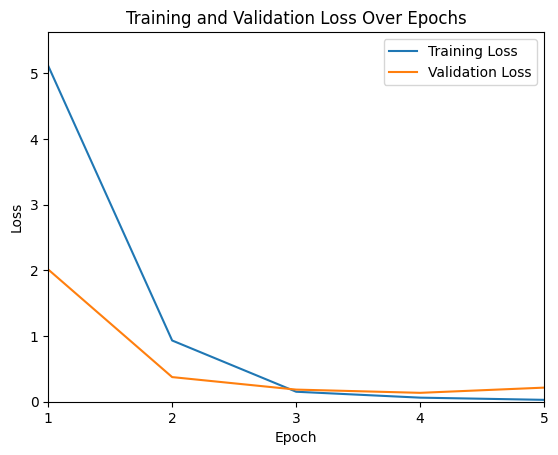

In [ ]:
plt.plot(np.arange(1,6),train_loss_history, label='Training Loss')
plt.plot(np.arange(1,6),val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')  # Add a title
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()
plt.xlim(1, 5)  # Optionally, set the x-axis limits
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)) * 1.1)  # Set y-axis limits dynamically
plt.xticks(np.arange(1, 6, step=1))
plt.show()


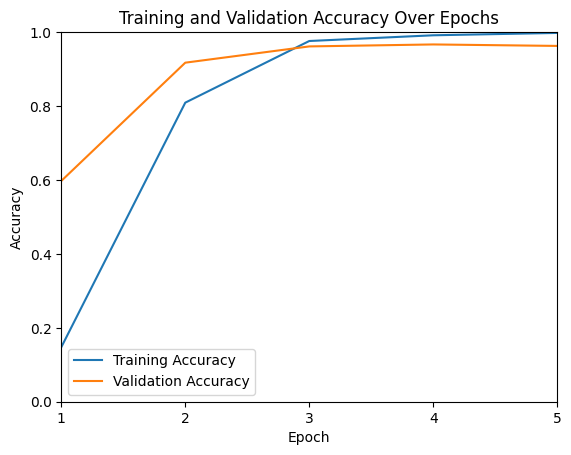

In [ ]:
plt.plot(np.arange(1,6),[i.cpu() for i in train_acc_history], label='Training Accuracy')
plt.plot(np.arange(1,6),[i.cpu() for i in val_acc_history], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')  # Add a title
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()
plt.xlim(1, 5)  # Optionally, set the x-axis limits
plt.ylim(0, 1)  # Set y-axis limits dynamically
plt.xticks(np.arange(1, 6, step=1))
plt.show()


# Closed set evaluation

In [ ]:
def get_model(checkpoint_path, num_classes=750):
    model = efficientnet_b1()
    in_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_ftrs, num_classes)
    input_size = 224
    model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu')))
    return model, input_size

def get_dataloader(data_path, input_size, batch_size=32):

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_path, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
checkpoint_path = "./best_models/effnet_e_5_lr_0_001_best.pth"

test_data_path = "./CASIA_1/test"

print("Loading model...")
model, input_size = get_model(checkpoint_path)

device = torch.device('cpu')
model.to(device)
model.eval()

dataloader = get_dataloader(test_data_path, input_size)

print("Running evaluation....")
rank_n = 50
total = 0
labels_true=np.array([0])
labels_pred=np.array([0])
labels_probabilities=np.empty((0,750))
rank_n_correct = np.zeros(rank_n)
with torch.no_grad():
    for inputs, labels in tqdm(dataloader):
        input = inputs.to(device)
        prediction = model(input).cpu()
        _, preds = torch.max(prediction, 1)

        labels_np = labels.detach().numpy()
        labels_true=np.concatenate((labels_true,labels_np))
        labels_pred=np.concatenate((labels_pred,preds.detach().numpy()))
        labels_prob = softmax(prediction, dim=1).detach().numpy()
        labels_probabilities=np.concatenate((labels_probabilities,labels_prob))
        rank_n_pred = (-labels_prob).argsort(axis=-1)[:, :rank_n]
        for i in range(labels_np.size):
            rank_n_pred_ith_label = list(rank_n_pred[i,:])
            total +=1
            for rank in range(rank_n):
                rank_n_correct[rank] += 1 if labels_np[i] in rank_n_pred_ith_label[:rank+1] else 0

rank_n_correct /= total

rank_1_accuracy = rank_n_correct[0]
rank_5_accuracy = rank_n_correct[4]

print(f"Rank-1 accuracy: {rank_1_accuracy}, rank-5 accuracy: {rank_5_accuracy}")

results = {
    "rank_1_acc": rank_1_accuracy,
    "rank_5_acc": rank_5_accuracy,
    "rank_n_accuracies": list(rank_n_correct)
}

# pathlib.Path("./results_closed_set").mkdir(parents=True, exist_ok=True)

with open(f'./results_closed_set/effnet_results_closed_set.json', 'w') as f:
    json.dump(results, f)

Loading model...
Running evaluation....


100%|██████████| 24/24 [06:01<00:00, 15.07s/it]


Rank-1 accuracy: 0.9773333333333334, rank-5 accuracy: 0.9986666666666667


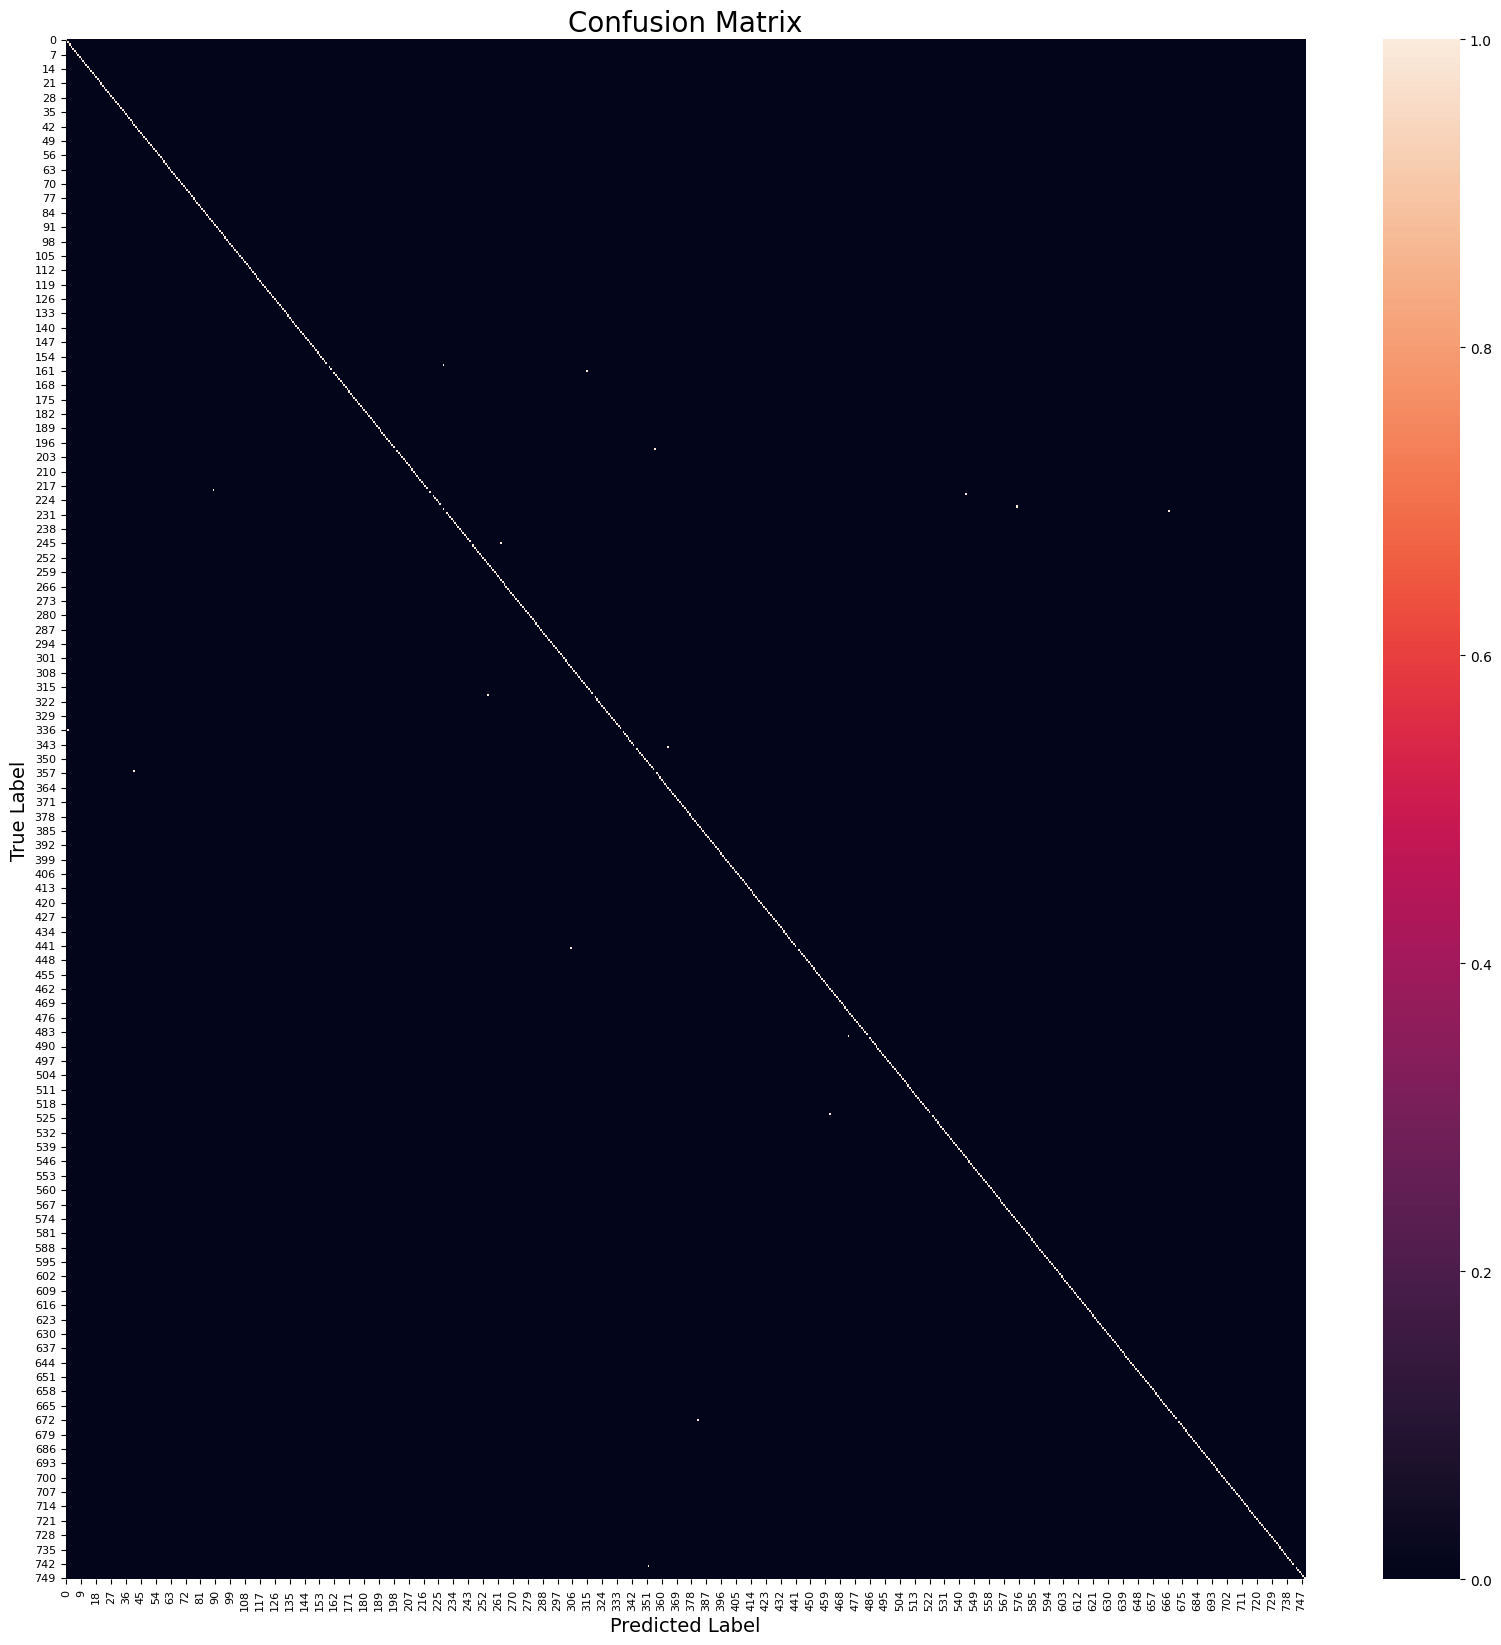

In [ ]:
labels_true=labels_true[1:]
labels_pred=labels_pred[1:]
cm = confusion_matrix(labels_true, labels_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label',fontsize=14)
plt.ylabel('True Label',fontsize=14)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
labels_ground_truth = np.zeros((len(labels_true), 750))

# Set 1 at each index specified in A
for i, index in enumerate(labels_true):
    labels_ground_truth[i, index] = 1

In [ ]:
roc_auc = roc_auc_score(labels_ground_truth, labels_probabilities, average='macro', multi_class='ovr')
roc_auc

0.9999946595460615

# Demo

In [ ]:
def get_dataloader_demo(data_path, input_size, batch_size=1):

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_path, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


Loading model...
Choosing random image...
Evaluating...
True id: 60
Predicted id is  60  with probability  0.99808383
Input image:


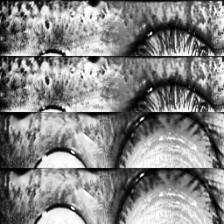

In [ ]:
checkpoint_path = "./best_models/effnet_e_5_lr_0_001_best.pth"

test_data_path = "./CASIA_1/test"

print("Loading model...")
model, input_size = get_model(checkpoint_path)

device = torch.device('cpu')
model.to(device)
model.eval()

#generate random id
print("Choosing random image...")
dataloader = get_dataloader_demo(test_data_path, 224)
input, label = next(iter(dataloader))
transform=transforms.ToPILImage()
mean = torch.tensor([0.485, 0.456, 0.406])  # mean of your dataset
std = torch.tensor([0.229, 0.224, 0.225])  # std of your dataset
im = std * input[0].permute(1,2,0) + mean
im = transform(im.permute(2,0,1))

print('Evaluating...')
with torch.no_grad():
  input = input.to(device)
  prediction = model(input).cpu()
  _, preds = torch.max(prediction, 1)
  labels_prob = softmax(prediction, dim=1).detach().numpy()
print('True id:',label.detach().numpy()[0])
print('Predicted id is ',preds.detach().numpy()[0], ' with probability ', labels_prob[0,preds[0]])
print('Input image:')
im